In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network

In [2]:
movies = pd.read_csv('movies.dat', sep = '::', encoding = 'latin1', header = None, engine = 'python')
movies.rename(columns = {2 : 'genres'}, inplace = True)
movies.head()

,0,1,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
genresSet = set()
#Put all the different genres in a set
for item in movies['genres']:
    for w in item.split('|'):
        genresSet.add(w)
    
genresList = list(genresSet)

In [4]:
#Create a list containing all the pairings possible
relations = []
for i in range(len(genresList)):
    
    for j in range(i):
        hits = movies[(movies['genres'].str.contains(genresList[i])) & 
                      (movies['genres'].str.contains(genresList[j]))].shape[0]
        relations.append([genresList[i], genresList[j], hits])

In [5]:
df = pd.DataFrame(relations, columns = ['from', 'to', 'value'])

Get rid of every row where value is < 20, to make the network manageable

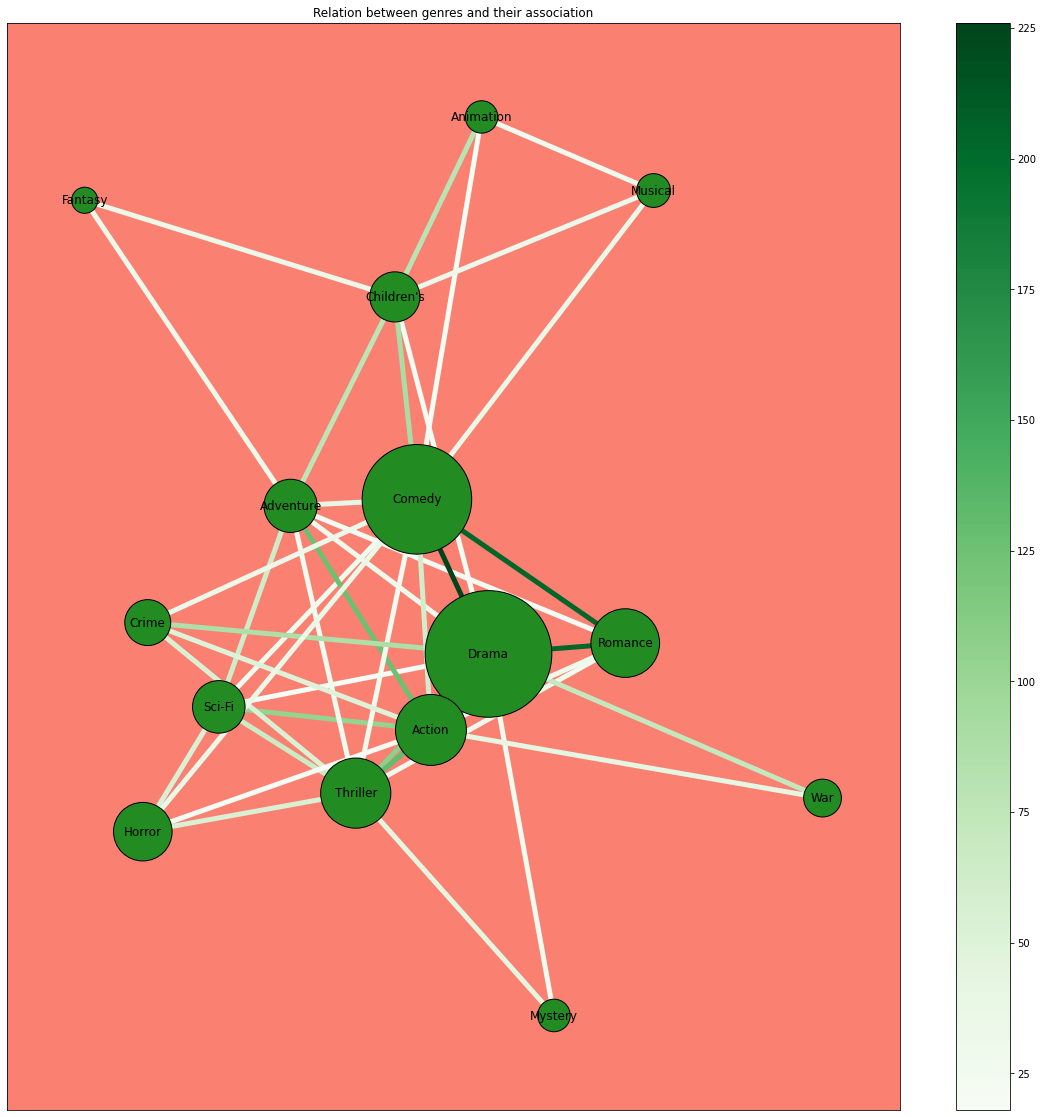

In [6]:
df = df[df['value'] > 20]
#df['value'] = df['value']/df['value'].max() normalize?
fig, ax = plt.subplots(figsize=(20,20))

G = nx.from_pandas_edgelist(df, 'from', 'to', edge_attr = 'value')

#When making nx read from a dataframe, the edges get somehow sorted. To make the edges values 
#match their actual edges, it is necessary to rearrange the values.
#Get the edges (AKA lines) of the network
edges = G.edges
orderedEdges = []
#Each edge is a tuple containing two Strings. loop through them
for edge in edges:
    #get_edge_data returns a dictionary
    tempDict = G.get_edge_data(edge[0], edge[1])
    #since we put 'value' as edge_attr we have a single key='value' with a single item. The occurrence
    orderedEdges.append(tempDict['value'])

#Rearrange the frequency of appearance of each node, so that it matches the node list in the element G
nodesList = list(G.nodes)
nodeWeight = []
for node in nodesList:
    x = movies[movies['genres'].str.contains(node)].shape[0]
    nodeWeight.append(10*x)
    
#With these two lists, nodeWeight and orderedEdges, we can control the node size and the edge color,
#which results in a better plot.
nt = nx.draw_networkx(G, with_labels=True, node_color='forestgreen', node_size=nodeWeight, 
        width=5, edge_cmap=plt.cm.Greens, edge_color = orderedEdges, linewidths = 1,
        ax = ax)
#networkx is a bit of a mess, so to control the outlines we have to call ax.collections
ax.collections[0].set_edgecolor("Black")
ax.set_facecolor('salmon')
ax.set_title('Relation between genres and their association')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Greens, norm=plt.Normalize(vmin=df['value'].min()-5, vmax=df['value'].max()))
plt.colorbar(sm)

The radius of the nodes is related with the frequency of appearance of the genre, the color of the edges connecting two nodes represents the number of times these genres have been together. Some insights this graph shows are: 

Drama, Comedy and Romance are frequently used genres and they also frequently appear together in a movie.  

Action, Thriller and Adventure are also popular genres, but you are more likely to see Action-Adventure or Action-Thriller movies, and very unlikely to see a Thriller-Adventure one.  

Children, and Children is usually presented along Animation, Adventure and Comedy, but not with Romance (less than 20 associations in the dataset).